pip install --quiet transformers==4.38.2

In [1]:
!pip install torchtext

In [2]:
pip install transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 64.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
Note: you may need to restart the kernel to use updated packages.


In [3]:
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [4]:
!pip install pytorch-lightning
!pip install tensorboard

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [6]:
# import torchtext

# # Kiểm tra phiên bản của torchtext
# print("Phiên bản torchtext:", torchtext.__version__)

# # Thử import Batch từ torchtext.data
# try:
#     from torchtext.data import Batch
#     print("Import Batch thành công!")
# except ImportError as e:
#     print("Lỗi khi import Batch:", e)

In [7]:
import json
import pandas as pd
import numpy as np
import torch
import transformers
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

#from pytorch_lightning.callbacks import ModelCheckpoint
#from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

In [8]:
df = pd.read_csv("/kaggle/input/vn-news/Dataset_articles_NoID-1.csv")

In [9]:
df = df.head(10000)
df = df[["Summary", "Contents"]]
df.columns = ["summary", "text"]

In [10]:
df = df.dropna()
df.head()

,summary,text
0,"Lâm Đồng - Lãnh đạo thành phố Bảo Lộc, Lâm Đồn...","Những ngày vừa qua, trên trang Facebook chính ..."
1,TPHCM - Việc không thể cưỡng chế thuế của hai ...,"Theo thông tin từ Cục Thuế TP.HCM, hiện cơ qua..."
2,"Hiện trên địa bàn tỉnh Ninh Bình có 32 khu, cụ...",CNLĐ mong muốn sớm được tiếp cận với nhà ở xã ...
3,Hoàn công nhà ở với ý nghĩa là điều kiện để đư...,Hoàn công nhà ở là một thủ tục hành chính tron...
4,Có rất nhiều lý do khiến những dự án thấp nội ...,Đi dọc đường Lê Văn Lương kéo dài xuống khu Dư...


In [11]:
import re

In [12]:
# # Hàm để làm sạch văn bản
# def clean_text_vietnamese(text):
#     # Loại bỏ các ký tự không phải chữ cái tiếng Việt, số và dấu cách
#     text = re.sub(r'[^a-zA-Z0-9\sÀ-ỹ]', '', text)
#     return text


# # Áp dụng hàm clean_text_vietnamese cho cột 'content' và 'title'
# df['summary'] = df['summary'].apply(clean_text_vietnamese)
# df['text'] = df['text'].apply(clean_text_vietnamese)

In [13]:
print(df.iloc[0]["text"])

Những ngày vừa qua, trên trang Facebook chính chủ của Ngọc Trinh có đăng tải thông tin người mẫu này vừa mua 11ha đất với homestay tại xã Đại Lào, TP.Bảo Lộc, thu hút sự chú ý lớn từ đông đảo cộng đồng mạng.  Sau đó, một số trang thông tin và mạng xã hội khác tiếp tục đăng tại lại thông tin này, đồng thời khẳng định, khu đất Ngọc Trinh mới mua nằm tại xã Đại Lào, TP.Bảo Lộc, tọa lạc ở vị trí đắc địa, tiếp giáp núi và có khí hậu mát mẻ dễ chịu, thích hợp cho kỳ nghỉ trốn nắng hè cho du khách. Trước thông tin này, ông Đoàn Kim Đình - Chủ tịch UBND thành phố Bảo Lộc cho biết, UBND thành phố đã yêu cầu cơ quan chức năng và UBND xã Đại Lào phối hợp kiểm chứng thông tin. Qua xác minh, khu đất Ngọc Trinh chụp hình và đăng tải lên mạng xã hội thuộc hẻm 61 B’Lao Srê, xã Đại Lào. Nhưng đây không phải là đất xây dựng homestay của Ngọc Trinh. Trong các hồ sơ thủ tục liên quan đất đai trên địa bàn xã Đại Lào không có chủ nhân nào tên là Trần Thị Ngọc Trinh (tên thật của Ngọc Trinh).  Mặt khác tất c

In [14]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale = 1.2)
rcParams['figure.figsize'] = 16,10

In [16]:
import pytorch_lightning as pl

# Sử dụng seed_everything từ PyTorch Lightning
pl.seed_everything(42)

42

In [17]:
train_df, test_df = train_test_split(df, test_size = 0.1)
train_df.shape, test_df.shape

((8770, 2), (975, 2))

In [18]:
class NewsSummaryDataset(Dataset):
 def __init__(
      self,
      data: pd.DataFrame,
      tokenizer: T5Tokenizer,
      text_max_token_len: int = 512,
      summary_max_token_len: int = 128
 ):
   self.tokenizer = tokenizer
   self.data = data
   self.text_max_token_len = text_max_token_len
   self.summary_max_token_len = summary_max_token_len
 def __len__(self):
   return len(self.data)
 def __getitem__(self, index : int):
   data_row = self.data.iloc[index]

   text = data_row["text"]
   text_encoding = tokenizer(
       text,
       max_length = self.text_max_token_len,
       padding = "max_length",
       truncation = True,
       return_attention_mask = True,
       add_special_tokens = True,
       return_tensors = "pt"
   )
   summary_encoding = tokenizer(
       data_row["summary"],
       max_length = self.summary_max_token_len,
       padding = "max_length",
       truncation = True,
       return_attention_mask = True,
       add_special_tokens = True,
       return_tensors = "pt"
   )
   labels = summary_encoding["input_ids"]
   labels[labels == 0] = -100

   return dict(
       text = text,
       summary = data_row["summary"],
       text_input_ids = text_encoding["input_ids"].flatten(),
       text_attention_mask = text_encoding["attention_mask"].flatten(),
       labels = labels.flatten(),
       labels_attention_mask = summary_encoding["attention_mask"].flatten()
   )

In [19]:
class NewsSummaryDataModule(pl.LightningDataModule):
   def __init__(
       self,
       train_df: pd.DataFrame,
       test_df: pd.DataFrame,
       tokenizer: T5Tokenizer,
       batch_size: int = 8 ,
       text_max_token_len: int =512,
       summary_max_token_len: int = 128
   ):
       super().__init__()
       self.train_df = train_df
       self.test_df = test_df

       self.batch_size = batch_size
       self.tokenizer = tokenizer

       self.text_max_token_len = text_max_token_len
       self.summary_max_token_len = summary_max_token_len
   def setup(self, stage = None):
      self.train_dataset = NewsSummaryDataset(
          self.train_df,
          self.tokenizer,
          self.text_max_token_len,
          self.summary_max_token_len
      )
      self.test_dataset = NewsSummaryDataset(
          self.test_df,
          self.tokenizer,
          self.text_max_token_len,
          self.summary_max_token_len
      )
   def train_dataloader(self):
      return DataLoader(
          self.train_dataset,
          batch_size = self.batch_size,
          shuffle = True,
          num_workers = 2
      )
   def val_dataloader(self):
     return DataLoader(
       self.test_dataset,
       batch_size = self.batch_size,
       shuffle = True,
       num_workers = 2
     )

In [20]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [21]:
text_token_counts, summary_token_counts = [],[]

for _, row in train_df.iterrows():
  text_token_count = len(tokenizer.encode(row["text"]))
  text_token_counts.append(text_token_count)

  summary_token_count = len(tokenizer.encode(row["summary"]))
  summary_token_counts.append(summary_token_count)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'summary text token counts')

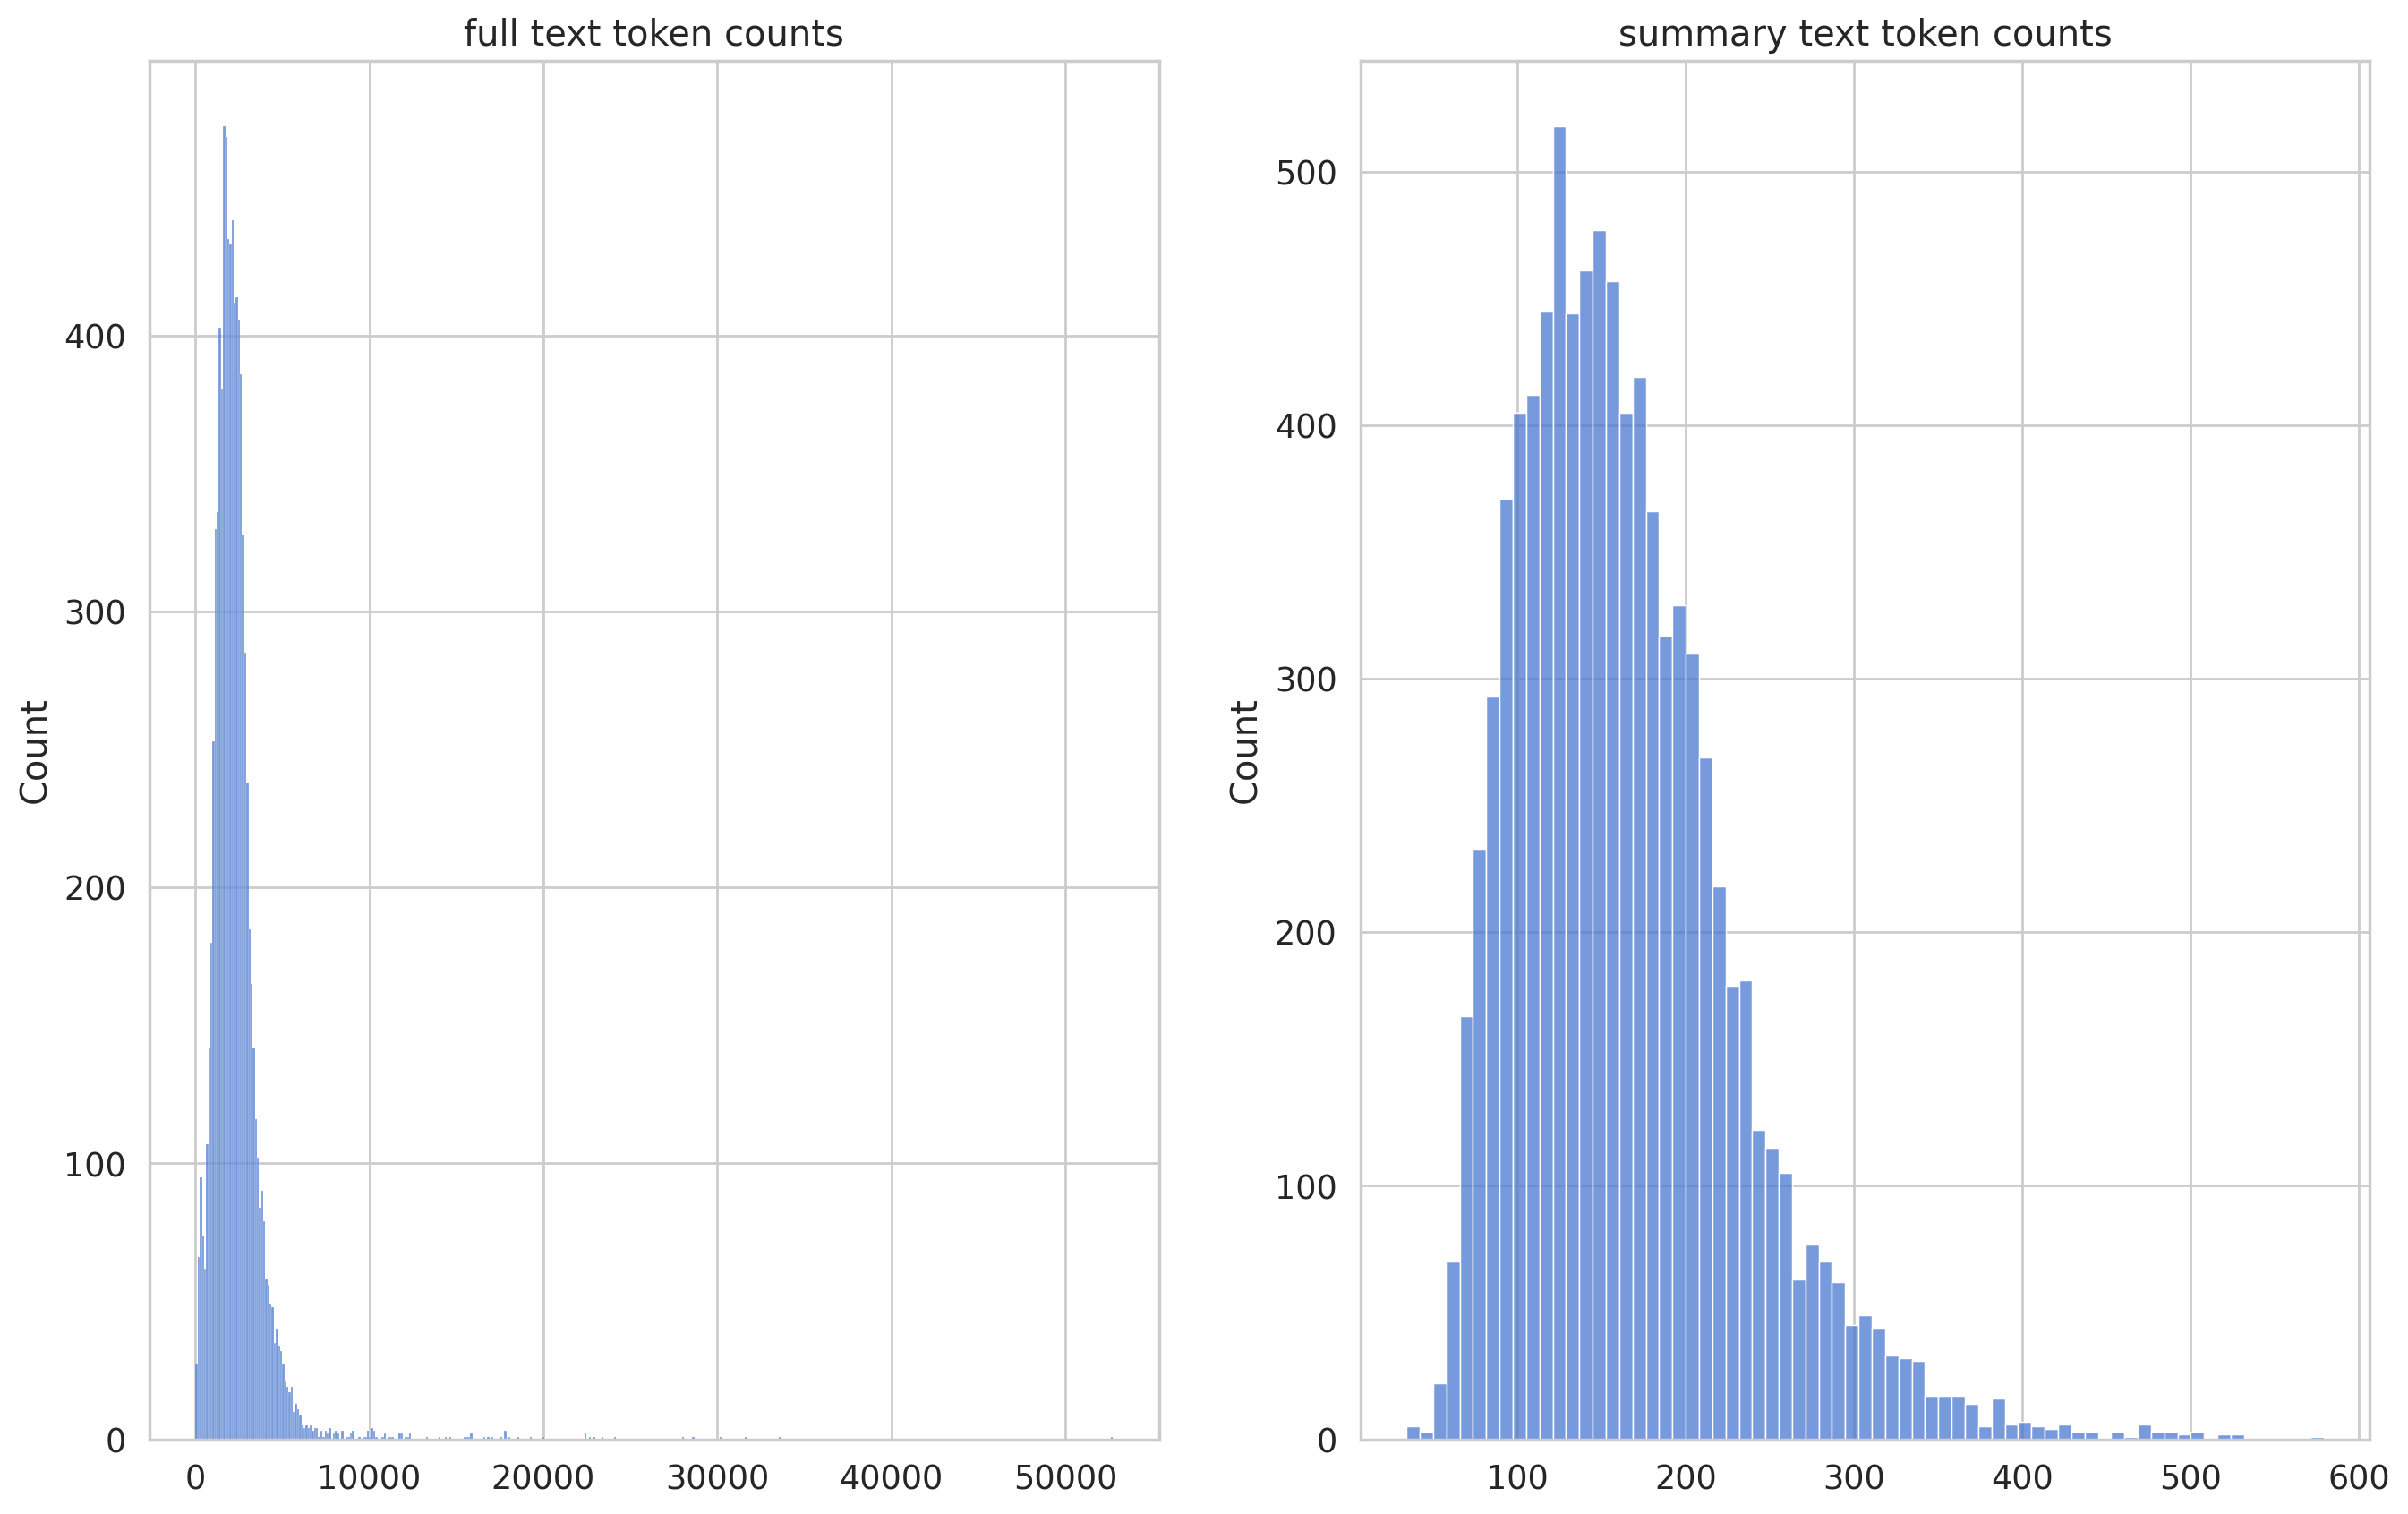

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts, ax = ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts, ax= ax2)
ax2.set_title("summary text token counts")

In [23]:
num_epochs = 3
BATCH_SIZE = 6

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer,batch_size = BATCH_SIZE)

In [24]:
class NewsSummaryModel(pl.LightningModule):
   def __init__(self):
     super().__init__()
     self.model =  T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)
   def forward(self, input_ids, attention_mask, decoder_attention_mask, labels = None):
     output = self.model(
         input_ids,
         attention_mask = attention_mask,
         labels = labels,
         decoder_attention_mask = decoder_attention_mask
     )

     return output.loss, output.logits

   def training_step(self, batch, batch_idx):
     input_ids = batch["text_input_ids"]
     attention_mask = batch["text_attention_mask"]
     labels = batch["labels"]
     labels_attention_mask = batch["labels_attention_mask"]

     loss, outputs = self(
         input_ids = input_ids,
         attention_mask = attention_mask,
         decoder_attention_mask = labels_attention_mask,
         labels = labels
     )
     self.log("train_loss", loss, prog_bar = True, logger = True)
     return loss
   def validation_step(self, batch, batch_idx):
     input_ids = batch["text_input_ids"]
     attention_mask = batch["text_attention_mask"]
     labels = batch["labels"]
     labels_attention_mask = batch["labels_attention_mask"]

     loss, outputs = self(
         input_ids = input_ids,
         attention_mask = attention_mask,
         decoder_attention_mask = labels_attention_mask,
         labels = labels
     )
     self.log("val_loss", loss, prog_bar = True, logger = True)
     return loss

   def test_step(self, batch, batch_idx):
     input_ids = batch["text_input_ids"]
     attention_mask = batch["text_attention_mask"]
     labels = batch["labels"]
     labels_attention_mask = batch["labels_attention_mask"]

     loss, outputs = self(
         input_ids = input_ids,
         attention_mask = attention_mask,
         decoder_attention_mask = labels_attention_mask,
         labels = labels
     )

     self.log("test_loss", loss, prog_bar = True, logger = True)
     return loss

   def configure_optimizers(self):
     return AdamW(self.parameters(), lr = 0.0001)

# Định nghĩa lớp đã được chạy, sau đó bạn có thể tạo instance
model = NewsSummaryModel()


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [25]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)
logger = TensorBoardLogger("lightning_logs", name="news-summary")

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=num_epochs,
    accelerator="gpu"
)

In [26]:
trainer.fit(model, data_module)

2024-03-28 16:55:47.708597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 16:55:47.708725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 16:55:47.830693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling para

Training: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: |          | 0/? [00:00<?, ?it/s]

In [30]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [32]:
def summarize(text):
    # Sử dụng tokenizer để mã hóa văn bản thành tensor
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # Chuyển tensor input lên GPU
    input_ids = text_encoding["input_ids"].to("cuda:0")
    attention_mask = text_encoding["attention_mask"].to("cuda:0")

    # Thực hiện tổng hợp
    generated_ids = trained_model.model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    # Giải mã các token sinh ra thành văn bản
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]

    # Kết hợp các văn bản sinh ra thành một văn bản duy nhất
    summary_result = "".join(preds)
    
    return summary_result

In [42]:

# # Lấy dòng thứ hai từ test_df
# sample_row = test_df.iloc[5]
# text = sample_row["text"]

text = "The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons."

# Thực hiện tổng hợp và in kết quả
summary_result = summarize(text)
print("Original Text:")
print(text)
print("\nSummarized Text:")
print(summary_result)

Original Text:
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.

Summarized Text:
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing 209 crore loss to the state-run bank.


In [46]:
# Thực hiện tổng hợp và in kết quả
summary_result = summarize(text)
print("Nội dung gốc:")
print(text)

Nội dung gốc:
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.


In [44]:
sample_row["summary"]

'Chủ tịch Ủy ban Trung ương MTTQ Việt Nam Đỗ Văn Chiến cho biết,\xa0trước diễn biến phức tạp của đại dịch, hình ảnh tăng ni cởi cà sa, khoác áo blouse, cùng xông pha vào nơi tuyến đầu chống dịch, chăm sóc bệnh nhân F0 tại bệnh viện dã chiến đã gây xúc động mạnh mẽ trong lòng nhân dân.'

In [45]:
print("Tin tức tóm tắt:")
print(summary_result)

Tin tức tóm tắt:
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing 209 crore loss to the state-run bank.


In [39]:
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [50]:
# Tải mô hình ROUGE
rouge = Rouge()

# Văn bản tóm tắt do mô hình tạo ra
hypothesis = "The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing 209 crore loss to the state-run bank."

# Văn bản tóm tắt tham khảo do con người tạo ra
reference = "CBI books ex-Syndicate Bank officials and others for cheating, forgery, and causing ₹209 crore loss. Accused obtained loans on forged documents."

# Tính toán ROUGE-L
scores = rouge.get_scores(hypothesis, reference)

# Lấy điểm số ROUGE-L cho câu đầu tiên trong danh sách
rouge_l_score = scores[0]['rouge-l']['f']

# In kết quả
print(f"ROUGE-L: {rouge_l_score}")


ROUGE-L: 0.46808510149388866
